# Testing Variational Autoencoder on synthetic data


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as s
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import contrib
from tensorflow.contrib import layers
from tensorflow.contrib.slim import fully_connected

In [3]:
class VariationalAutoencoder(object):
    """Varational Autoencoder.
    """

    def __init__(self, config):
        """Initializes a VAE.
        Args:
            config(dict): JSON FILE
            name(string): naming the session (default: model)
        """
        self._name = config['name']
        self._ndims = config['ndims']
        self._nlatent = config['nlatent']
        
        # Paths
        self._save_path = config['path']['save']
        self._load_path = config['path']['load']
        
        # Architecture
        self._encoder_h1 = config['encoder']['h1']
        self._encoder_h2 = config['encoder']['h2']
        self._decoder_h1 = config['decoder']['h1']
        self._decoder_h2 = config['decoder']['h2']
        
        # loss weights (Ad-hoc)
        self._reconstruction_loss_weight = config['weights']['reconstruction']
        self._latent_loss_weight = config['weights']['latent']

        # Create session
        self.session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_placeholder = tf.placeholder(tf.float32, [None, self._ndims])
        self.learning_rate_placeholder = tf.placeholder(tf.float32, [])

        # Build graph.
        self.z_mean, self.z_log_var = self._encoder(self.x_placeholder)
        self.z = self._sample_z(self.z_mean, self.z_log_var)
        self.outputs_tensor = self._decoder(self.z)

        # Setup loss tensor, predict_tensor, update_op_tensor
        self.loss_tensor, self.l, self.r = self.loss(self.outputs_tensor, self.x_placeholder,
                                                     self.z_mean, self.z_log_var)

        self.update_op_tensor = self.update_op(self.loss_tensor,
                                               self.learning_rate_placeholder)

        # Initialize all variables.
        self.session.run(tf.global_variables_initializer())
        
        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver()        
        

    def _sample_z(self, z_mean, z_log_var):
        """Samples z using reparametrization trick.
        Args:
            z_mean (tf.Tensor): The latent mean,
                tensor of dimension (None, _nlatent)
            z_log_var (tf.Tensor): The latent log variance,
                tensor of dimension (None, _nlatent)
        Returns:
            z (tf.Tensor): Random sampled z of dimension (None, _nlatent)
        """

        z = None
        
        z = z_mean + tf.sqrt(tf.exp(z_log_var)) * tf.random_normal(tf.shape(z_mean), 0, 1, dtype=tf.float32)
        return z

    def _encoder(self, x):
        """Encoder block of the network.
        Builds a two layer network of fully connected layers, with 100 nodes,
        then 50 nodes, and outputs two branches each with _nlatent nodes
        representing z_mean and z_log_var. Network illustrated below:
                             |-> _nlatent (z_mean)
        Input --> 100 --> 50 -
                             |-> _nlatent (z_log_var)
        Use activation of tf.nn.softplus for hidden layers.
        Args:
            x (tf.Tensor): The input tensor of dimension (None, _ndims).
        Returns:
            z_mean(tf.Tensor): The latent mean, tensor of dimension
                (None, _nlatent).
            z_log_var(tf.Tensor): The latent log variance, tensor of dimension
                (None, _nlatent).
        """
        z_mean = None
        z_log_var = None

        # fully connected layer 1 [input --> 100]
        fully_connected_1 = fully_connected(inputs=x, num_outputs=self._encoder_h1, activation_fn=tf.nn.softplus)

        # fully connected layer 2 [fl1 --> 50]
        fully_connected_2 = fully_connected(inputs=fully_connected_1, num_outputs=self._encoder_h2, activation_fn=tf.nn.softplus)

        # Output layer
        output = fully_connected(inputs=fully_connected_2, num_outputs=2 * self._nlatent, activation_fn=None)

        z_mean = output[:, 0:self._nlatent]
        z_log_var = output[:, self._nlatent:]

        return z_mean, z_log_var

    def _decoder(self, z):
        """From a sampled z, decode back into image.
        Builds a three layer network of fully connected layers,
        with 50, 100, _ndims nodes.
        z (_nlatent) --> 50 --> 100 --> _ndims.
        Use activation of tf.nn.softplus for hidden layers.
        Args:
            z(tf.Tensor): z from _sample_z of dimension (None, _nlatent).
        Returns:
            f(tf.Tensor): Decoded features, tensor of dimension (None, _ndims).
        """

        f = None
        
        # fully connected layer 1 [_nlatent --> 50]
        fully_connected_1 = fully_connected(inputs=z, num_outputs=self._decoder_h1, activation_fn=tf.nn.softplus)

        # fully connected layer 2 [50 --> 100]
        fully_connected_2 = fully_connected(inputs=fully_connected_1, num_outputs=self._decoder_h2, activation_fn=tf.nn.softplus)

        # Output layer
        f = fully_connected(inputs=fully_connected_2, num_outputs=self._ndims, activation_fn=tf.nn.softmax)
        return f

    def _latent_loss(self, z_mean, z_log_var):
        """Constructs the latent loss.
        Args:
            z_mean(tf.Tensor): Tensor of dimension (None, _nlatent)
            z_log_var(tf.Tensor): Tensor of dimension (None, _nlatent)
        Returns:
            latent_loss(tf.Tensor): A scalar Tensor of dimension ()
                containing the latent loss.
        """
        latent_loss = None
        
        latent_loss = tf.reduce_mean(0.5 * tf.reduce_sum(-1 - z_log_var + (tf.square(z_mean) + tf.exp(z_log_var)), 1))
        return latent_loss

    def _reconstruction_loss(self, f, x_gt):
        """Constructs the reconstruction loss, assuming Gaussian distribution.
        Args:
            f(tf.Tensor): Predicted score for each example, dimension (None,
                _ndims).
            x_gt(tf.Tensor): Ground truth for each example, dimension (None,
                _ndims).
        Returns:
            recon_loss(tf.Tensor): A scalar Tensor for dimension ()
                containing the reconstruction loss.
        """
        recon_loss = None
        
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(f - x_gt), axis=1))
        
        return recon_loss

    def loss(self, f, x_gt, z_mean, z_var):
        """Computes the total loss.
        Computes the sum of latent and reconstruction loss.
        Args:
            f (tf.Tensor): Decoded image for each example, dimension (None,
                _ndims).
            x_gt (tf.Tensor): Ground truth for each example, dimension (None,
                _ndims)
            z_mean (tf.Tensor): The latent mean,
                tensor of dimension (None, _nlatent)
            z_log_var (tf.Tensor): The latent log variance,
                tensor of dimension (None, _nlatent)
        Returns:
            total_loss: Tensor for dimension (). Sum of
                latent_loss and reconstruction loss.
        """
        total_loss = None
        
        latent_loss = self._latent_loss(z_mean, z_var)
        rec_loss = self._reconstruction_loss(f, x_gt)
        
        total_loss = self._latent_loss_weight*latent_loss + self._reconstruction_loss_weight*rec_loss
        
        return total_loss, latent_loss, rec_loss

    def update_op(self, loss, learning_rate):
        """Creates the update optimizer.
        Use tf.train.AdamOptimizer to obtain the update op.
        Args:
            loss(tf.Tensor): Tensor of shape () containing the loss function.
            learning_rate(tf.Tensor): Tensor of shape (). Learning rate for
                gradient descent.
        Returns:
            train_op(tf.Operation): Update opt tensorflow operation.
        """
        train_op = None
        
        train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        return train_op

    def generate_samples(self, z_np):
        """Generates random samples from the provided z_np.
        Args:
            z_np(numpy.ndarray): Numpy array of dimension
                (batch_size, _nlatent).
        Returns:
            out(numpy.ndarray): The sampled images (numpy.ndarray) of
                dimension (batch_size, _ndims).
        """
        out = None
        
        out = self.outputs_tensor.eval(session=self.session, feed_dict={self.z: z_np})
        return out
      
    def encode_samples(self, x):
        """Encode samples from the provided features
        Args:
            x(numpy.ndarray): Numpy array of dimension
                (batch_size, _ndims).
        Returns:
            embeddings(numpy.ndarray): The embeddings (numpy.ndarray) of
                dimension (batch_size, _nlatent).
        """
        embeddings = None
        
        embeddings = self.z.eval(session=self.session, feed_dict={self.x_placeholder: x})
        return embeddings
      
    def model_accuracy(self):
        """Creates accuracy tensor.
        Use tf.train.AdamOptimizer to obtain the update op.
        Returns:
            accuracy(tf.Tensor) : Accuracy tensor, dimensions ().
        """
        x_decoded_tensor = tf.cast(tf.argmax(self.outputs_tensor, axis=1), tf.int64)
        x_true_tensor = tf.cast(tf.argmax(self.x_placeholder, axis=1), tf.int64)
        correct_prediction = tf.equal(x_decoded_tensor, x_true_tensor)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

    def score(self, x):
        """Scoring function.
        Score is the evaluation of accuracy tensor

        Args:
            x(np.array): The feature vector, dimension(batch, _ndims)
            y(np.array): The label vector, dimension(batch, )
        Returns:
            score(float): evaluated accuracy value.
        """
        acc = self.model_accuracy()
        score = acc.eval(session=self.session, feed_dict={self.x_placeholder: x})
        return score
      
    def load(self, path=None, name=None, ext='.ckpt'):
        """Scoring function.
        Score is the evaluation of accuracy tensor

        Args:
            x(np.array): The feature vector, dimension(batch, _ndims)
            y(np.array): The label vector, dimension(batch, )
        Returns:
            score(float): evaluated accuracy value.
        """
        if not name:
            name = self._name
          
        if not path:
            path = self._load_path
          
        self.saver.restore(self.session, (path+name+ext))
    
    
    def save(self, path=None , name=None, ext='.ckpt'):
        """Scoring function.
        Score is the evaluation of accuracy tensor

        Args:
            x(np.array): The feature vector, dimension(batch, _ndims)
            y(np.array): The label vector, dimension(batch, )
        Returns:
            score(float): evaluated accuracy value.
        """
        if not name:
            name = self._name
        
        if not path:
            path = self._save_path
          
        save_path = self.saver.save(self.session, (path+name+ext))
        print("Model saved in path: %s" % save_path)

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
def make_batches(pd, batch_size):
    containers = int(np.floor((pd[0].shape[0]) / batch_size))
    remaining = ((pd[0].shape[0]) % batch_size)
    batch = []
    for i in range(0, containers):
        batch_x = pd[0][i * batch_size:((i + 1) * batch_size), :]
        batch.append([batch_x])
    if (remaining):
        batch_x = pd[0][(i + 1) * batch_size:(i + 1) * batch_size + remaining, :]
        batch.append([batch_x])
    return batch

In [6]:
def train(model, dataset, learning_rate=0.0005, batch_size=16,
          epochs=20):
    """Implements the training loop of mini-batch gradient descent.
    Performs mini-batch gradient descent with the indicated batch_size and
    learning_rate.
    Args:
        model(VariationalAutoencoder): Initialized VAE model.
        mnist_dataset: Mnist dataset.
        learning_rate(float): Learning rate.
        batch_size(int): Batch size used for training.
        num_steps(int): Number of steps to run the update ops.
    """
    avg_loss = []
    
    for epoch in range(1, epochs+1):
      
        # shuffle the data after every epoch      
        np.random.shuffle(dataset)
        
        # make batches
        batches = make_batches([dataset],batch_size)
        
        # cache
        batch_loss = []
        
        # iterate over all batches
        for batch in batches:
            batch_x = batch[0]
            
            feed_dict_train = {model.x_placeholder: batch_x,
                               model.learning_rate_placeholder: learning_rate}
            
            session_list = [model.update_op_tensor, model.loss_tensor, model.l, model.r]
            
            
            # Running the model session
            _, loss_val, l, r = model.session.run(session_list,
                                               feed_dict=feed_dict_train)
            
            # cache updates
            batch_loss.append(loss_val)

            
        # average loss calculation through cache
        average_loss_value = sum(batch_loss) / float(len(batch_loss))
        avg_loss.append(average_loss_value)
        
        "Display : verbose"
        if epoch % 2 == 0 or epoch == epochs:

            # Message for printing.
            msg = "Epoch: {0:>6}, Avg. loss: {1:>6.4f}, Latent loss: {2:>6.4f}, Reconstruction loss: {3:>6.4f}"

            # Print it.
            print(msg.format(epoch, average_loss_value, l, r))

        if epoch == epochs:

            import matplotlib.pyplot as plt
            import seaborn as sns

            sns.set()
            plt.figure(figsize = (10,6))
            
            plt.plot(running_mean(avg_loss,1))

            plt.xlabel('Steps')
            plt.ylabel('Loss value')
            plt.title('Loss Curve')
            plt.show()
            
            

In [7]:
def get_synthetic_data(classes=2, sample_size=1000):

    syn_onehot = np.zeros((classes*sample_size,classes), dtype=np.int8)
    for i in range(classes):
        syn_onehot[i*sample_size:(i*sample_size)+sample_size, i] = 1
    return syn_onehot

Epoch:      2, Avg. loss: 0.4679, Latent loss: 369.1716, Reconstruction loss: 0.0002


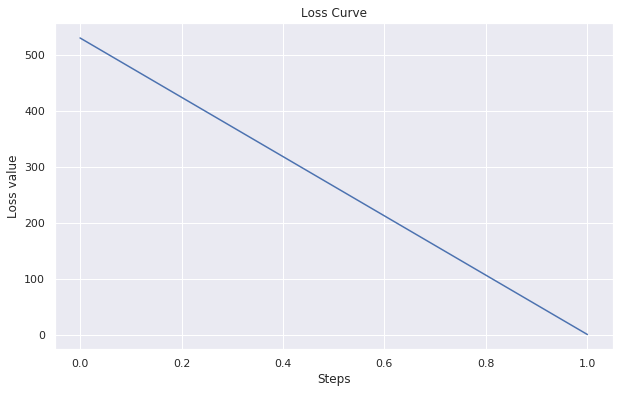

Model saved in path: ./synthetic/synthetic_vae.ckpt


In [9]:
# Data
syn_onehot = get_synthetic_data(10, 1000)

# configuration dictionary
config = {'name' : 'synthetic_vae',
          'ndims': syn_onehot.shape[1],
          'nlatent': 10,
          'encoder': {'h1': 100,'h2': 50},
          'decoder': {'h1': 50, 'h2': 100},
          'weights': {'reconstruction':1000, 'latent':0.00001},
          'path': {'save':'./synthetic/', 'load':'./synthetic/'}
          }          

# Build model.
model = VariationalAutoencoder(config)

# Start training
train(model, syn_onehot, learning_rate=0.0005, batch_size=16, epochs=2)

# Save
model.save()

In [10]:
model.load()
acc = model.score(get_synthetic_data(10, 1000))
print('Accuracy: {0:>6.2%}'.format(acc))

INFO:tensorflow:Restoring parameters from ./synthetic/synthetic_vae.ckpt
Accuracy: 100.00%


In [0]:
embeddings = model.encode_samples(get_synthetic_data(10, 1000))

# DeepAir Dataset

### Environment Setup

- Download 2M dataset from the server.


In [11]:
!bash dataset.sh




connecting server..

--2019-01-09 19:40:14--  https://drive.google.com/uc?export=download&id=1j7PNpD24Qoc9aA5843GYUuyKZzRXIVnt
Resolving drive.google.com (drive.google.com)... 173.194.198.102, 173.194.198.138, 173.194.198.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.198.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mvah6rccg5br7i0jfththodj0nbrep5m/1547056800000/08923193926105896987/*/1j7PNpD24Qoc9aA5843GYUuyKZzRXIVnt?e=download [following]
--2019-01-09 19:40:15--  https://doc-0o-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mvah6rccg5br7i0jfththodj0nbrep5m/1547056800000/08923193926105896987/*/1j7PNpD24Qoc9aA5843GYUuyKZzRXIVnt?e=download
Resolving doc-0o-a0-docs.googleusercontent.com (doc-0o-a0-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-0o-a0-docs.

#### Loading data and creating testset and training set

In [12]:
data_path = './data/2M_Data.csv'
data = pd.read_csv(data_path)
train_df = data[data['TRAIN_TEST']=='TRAIN']
test_df = data[data['TRAIN_TEST']=='TEST']
print('Train data shape : {}'.format(train_df.shape))
print('Test data shape : {}'.format(test_df.shape))

Train data shape : (31223, 85)
Test data shape : (13096, 85)


In [14]:
train_df.head()

,Row Number,ADT,CHD,INF,advanced_purchase,arrivalairportcode,arrivalcitycode,arrivaldate,arrivaldate_cos_dow,arrivaldate_cos_tod,...,utctimestamp_sin_woy,bag_paid_revenue,bag_paid_quantity,bag_paid_price,GROUP_SIZE,LOS_DAYS,AP_DAYS,DPTR_DOW,BAG_PRICE_ROUNDED,TRAIN_TEST
0,0,2,0,0,0.000000,25,25,2018-09-19 17:35,-0.222521,-0.258819,...,-0.992709,NaN,NaN,NaN,2,0,0,4-Wed,30,TRAIN
1,1,1,0,0,0.084932,25,25,2018-10-20 14:35,-0.222521,-0.866025,...,-0.992709,NaN,NaN,NaN,1,0,31,7-Sat,25,TRAIN
2,2,1,0,0,0.084932,25,25,2018-10-20 14:35,-0.222521,-0.866025,...,-0.992709,NaN,NaN,NaN,1,0,31,7-Sat,25,TRAIN
3,3,1,0,0,0.030137,25,25,2018-09-30 14:20,0.623490,-0.866025,...,-0.992709,NaN,NaN,NaN,1,0,11,1-Sun,20,TRAIN
4,4,1,0,0,0.035616,27,27,2018-10-02 17:20,0.623490,-0.258819,...,-0.992709,NaN,NaN,NaN,1,2,13,3-Tue,25,TRAIN


## 2M Bag Dataset - Advanced Purchase feature

#### Onehot Encoding :
For `advanced_purchase` feature, one hot encoding is done. THe days (feature value) will range from $0$ to $365$ and each of them is coded in one-hot fashion. 

In [13]:
df = train_df[['advanced_purchase']]*365
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],365), dtype=np.int8)
for i in range(x.shape[0]):
    x_onehot[i,x[i]]=1

### Configuration file for the experiment
To initiate a `Variational Autoencoder` session (to create an object of the vae class), a configuration dictionary is required. Below is an example of one such configuration dict. 

In [17]:
config = {'name' : 'Advanced_purchase_vae',
          'ndims': x_onehot.shape[1],
          'nlatent': 10,
          'encoder': {'h1': 100,'h2': 50},
          'decoder': {'h1': 50, 'h2': 100},
          'weights': {'reconstruction':1000, 'latent':0.00001},
          'path': {'save':'./AdvancedPurchase/', 'load':'./AdvancedPurchase/'}
          }

#### Training VAE model
training on `Advanced purchase` to find feature embeddings in latent space

Epoch:      2, Avg. loss: 350.5729, Latent loss: 402.9509, Reconstruction loss: 0.1445
Epoch:      4, Avg. loss: 333.2232, Latent loss: 275.5101, Reconstruction loss: 0.5870
Epoch:      6, Avg. loss: 339.7876, Latent loss: 275.8636, Reconstruction loss: 0.4342
Epoch:      8, Avg. loss: 347.8410, Latent loss: 236.5086, Reconstruction loss: 0.2904
Epoch:     10, Avg. loss: 365.6545, Latent loss: 177.6088, Reconstruction loss: 0.3057
Epoch:     12, Avg. loss: 357.3166, Latent loss: 223.1665, Reconstruction loss: 0.2894
Epoch:     14, Avg. loss: 356.4448, Latent loss: 155.1427, Reconstruction loss: 0.2894
Epoch:     16, Avg. loss: 343.7939, Latent loss: 215.5603, Reconstruction loss: 0.1448
Epoch:     18, Avg. loss: 335.0257, Latent loss: 136.9842, Reconstruction loss: 0.5790
Epoch:     20, Avg. loss: 306.0880, Latent loss: 170.6087, Reconstruction loss: 0.1446
Epoch:     22, Avg. loss: 309.7478, Latent loss: 186.9756, Reconstruction loss: 0.4342
Epoch:     24, Avg. loss: 308.9025, Latent 

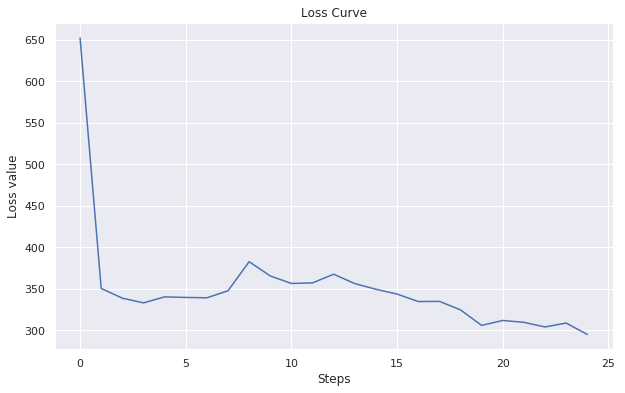

Model saved in path: ./AdvancedPurchase/Advanced_purchase_vae.ckpt


In [18]:
# Build model.
model = VariationalAutoencoder(config)

# Start training
train(model, x_onehot, learning_rate=0.0005, batch_size=16, epochs=25)

# Save
model.save()

In [19]:
model.load()

INFO:tensorflow:Restoring parameters from ./AdvancedPurchase/Advanced_purchase_vae.ckpt


#### Testing VAE

In [20]:
# one hot encode the test feature
df = test_df[['advanced_purchase']]*365
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],365), dtype=np.int8)
for i in range(x.shape[0]):
    x_onehot[i,x[i]]=1
    
# Calculate the model accuracy
acc = model.score(x_onehot)
print('Feature reconstruction accuracy: {0:>6.2%}'.format(acc))

Feature reconstruction accuracy: 71.92%


## 2M Bag Dataset - LOS (length of stay) feature
#### Onehot Encoding :
For `LOS` feature, also one hot encoding is done. The days (feature value) will range now from $0$ to $31+$. 

The way we encoded these feature into one-hot is: 
$0$ - $31$ (32 dim) and $32+$ (1 dim) making total of 33 dimensional onehot encoded vector.

In [0]:
df = train_df[['LOS_DAYS']]
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],33), dtype=np.int8)
for i in range(x.shape[0]):
    if x[i] >31:
        x_onehot[i,32]=1
    else:
        x_onehot[i,x[i]]=1

### Configuration dictionary for the experiment

In [ ]:
config = {'name' : 'LOS_vae',
          'ndims': x_onehot.shape[1],
          'nlatent': 3,
          'encoder': {'h1': 100,'h2': 50},
          'decoder': {'h1': 50, 'h2': 100},
          'weights': {'reconstruction':1000, 'latent':0.00001},
          'path': {'save':'./LOS/', 'load':'./LOS/'}
          }

In [ ]:
# Build model.
model = VariationalAutoencoder(config)

# Start training
train(model, x_onehot, learning_rate=0.0005, batch_size=16, epochs=25)

#save
model.save()

#### Testing VAE encoding performance on LOS feature embedding

In [0]:
df = test_df[['LOS_DAYS']]
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],33), dtype=np.int8)
for i in range(x.shape[0]):
    if x[i] >31:
        x_onehot[i,32]=1
    else:
        x_onehot[i,x[i]]=1

In [0]:
model.load()
acc = model.score(x_onehot)
print('Accuracy: {0:>6.2%}'.format(acc))

INFO:tensorflow:Restoring parameters from ./VAE/LOS/LOS_vae.ckpt
Accuracy: 98.61%


## 2M Bag Dataset - Group Size feature
#### Onehot Encoding :
For `Group Size` feature, also one hot encoding is done. The member in group (feature value) will range from $1$ to $10+$. 

The way we encoded these feature value into one-hot is: 
$1$ - $4$ (4 dim) and $5+$ (1 dim) making total of 5 dimensional onehot encoded vector.

In [0]:
df = train_df[['GROUP_SIZE']]
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],5), dtype=np.int8)
for i in range(x.shape[0]):
    if x[i] >4:
        x_onehot[i,4]=1
    else:
        x_onehot[i,x[i]-1]=1

Epoch:      2, Avg. loss: 26.9935, Latent loss: 123.7921, Reconstruction loss: 0.0001
Epoch:      4, Avg. loss: 26.6904, Latent loss: 102.6105, Reconstruction loss: 0.0001
Epoch:      6, Avg. loss: 0.0251, Latent loss: 212.1620, Reconstruction loss: 0.0000
Epoch:      8, Avg. loss: 0.0069, Latent loss: 242.3061, Reconstruction loss: 0.0000
Epoch:     10, Avg. loss: 0.0040, Latent loss: 241.3470, Reconstruction loss: 0.0000
Epoch:     12, Avg. loss: 0.0032, Latent loss: 267.7228, Reconstruction loss: 0.0000
Epoch:     14, Avg. loss: 0.0028, Latent loss: 263.8126, Reconstruction loss: 0.0000
Epoch:     16, Avg. loss: 0.0024, Latent loss: 192.9008, Reconstruction loss: 0.0000
Epoch:     18, Avg. loss: 0.0019, Latent loss: 170.0698, Reconstruction loss: 0.0000
Epoch:     20, Avg. loss: 0.0014, Latent loss: 111.7527, Reconstruction loss: 0.0000


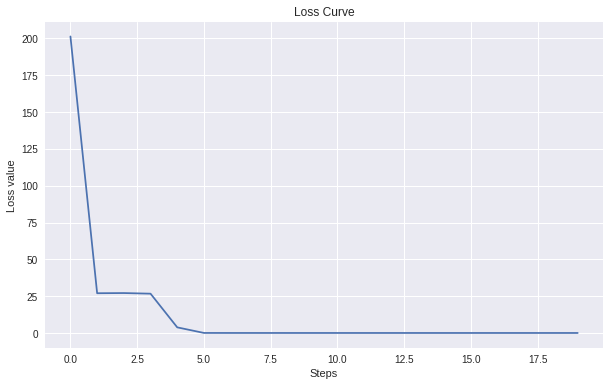

Model saved in path: ./VAE/GroupSize/GroupSize_vae.ckpt


In [0]:
config = {'name' : 'GroupSize_vae',
          'ndims': x_onehot.shape[1],
          'nlatent': 2,
          'encoder': {'h1': 100,'h2': 50},
          'decoder': {'h1': 50, 'h2': 100},
          'weights': {'reconstruction':1000, 'latent':0.00001},
          'path': {'save':'./VAE/GroupSize/', 'load':'./VAE/GroupSize/'}
          }

# Build model.
model = VariationalAutoencoder(config)

# Start training
train(model, x_onehot, learning_rate=0.0005, batch_size=16, epochs=20)

model.save()

In [0]:
df = test_df[['GROUP_SIZE']]
x = np.array(df).astype(int)
x_onehot = np.zeros((x.shape[0],5), dtype=np.int8)
for i in range(x.shape[0]):
    if x[i] >4:
        x_onehot[i,4]=1
    else:
        x_onehot[i,x[i]-1]=1

In [0]:
model.load()
acc = model.score(x_onehot)
print('Accuracy: {0:>6.2%}'.format(acc))

INFO:tensorflow:Restoring parameters from ./VAE/GroupSize/GroupSize_vae.ckpt
Accuracy: 100.00%
